In [26]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import norm

In [27]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

from market.five_paths import simulate_five_heston_paths

# import the basket payoff
from payoff.basket_option import basket_call_payoff

# import the 5D model + train function
from utils.multi_networks import RecurrentHedgeModel5D
from optimizer.hedge_train_5d import train_5D_cvar, compute_5D_pnl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
class HestonModel:
    def __init__(self, 
                 s0=100.0,
                 v0=0.04,
                 kappa=1.5,
                 theta=0.04,
                 xi=0.5,
                 rho=-0.7,
                 r=0.0,
                 dt=1/365,
                 seed=1234):
        self.s0 = s0
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho
        self.r = r
        self.dt = dt
        self.rng = np.random.default_rng(seed)

    def simulate_paths(self, n_paths=10000, n_steps=30):
        """
        Returns S, V each shape (n_paths, n_steps+1).
        S: underlying price
        V: instantaneous variance
        """
        S = np.zeros((n_paths, n_steps+1))
        V = np.zeros((n_paths, n_steps+1))
        S[:,0] = self.s0
        V[:,0] = self.v0

        cov = np.array([[1.0, self.rho],
                        [self.rho, 1.0]])
        L = np.linalg.cholesky(cov)

        for t in range(n_steps):
            Z = self.rng.normal(size=(n_paths, 2))
            dW = Z @ L.T
            dW1 = dW[:, 0] * np.sqrt(self.dt)
            dW2 = dW[:, 1] * np.sqrt(self.dt)

            vt = V[:, t]
            st = S[:, t]

            # Next variance
            V[:, t+1] = np.maximum(
                vt + self.kappa*(self.theta - vt)*self.dt + self.xi*np.sqrt(vt)*dW2,
                1e-10
            )
            # Next underlying
            S[:, t+1] = st * np.exp((self.r - 0.5*vt)*self.dt + np.sqrt(vt)*dW1)

        return S, V

In [29]:
###############################################################################
# 3) Simulate 5 uncorrelated Heston assets
###############################################################################
def simulate_five_heston_paths(n_paths=100000, n_steps=30, dt=1/365):
    """
    We'll call HestonModel(...) 5 times with different seeds & parameters
    to get 5 uncorrelated underlyings. Then stack them into shape
    (n_paths, n_steps+1, 5).
    """
    # Example param sets for each asset
    param_list = [
        dict(s0=100.0, v0=0.04, kappa=1.5, theta=0.04, xi=0.5, rho=-0.7, r=0.0, dt=dt, seed=1234),
        dict(s0=95.0,  v0=0.02, kappa=1.2, theta=0.02, xi=0.3, rho=-0.4, r=0.0, dt=dt, seed=4321),
        dict(s0=105.0, v0=0.05, kappa=1.7, theta=0.05, xi=0.6, rho=-0.8, r=0.0, dt=dt, seed=9999),
        dict(s0=80.0,  v0=0.03, kappa=1.5, theta=0.03, xi=0.5, rho=-0.7, r=0.0, dt=dt, seed=2023),
        dict(s0=120.0, v0=0.06, kappa=1.3, theta=0.06, xi=0.4, rho=-0.9, r=0.0, dt=dt, seed=7777),
    ]
    S_arr = []
    for params in param_list:
        model = HestonModel(**params)
        S_i, V_i = model.simulate_paths(n_paths, n_steps)
        S_arr.append(S_i)

    # shape => (5, n_paths, n_steps+1)
    S_arr = np.stack(S_arr, axis=0)
    # reorder => (n_paths, n_steps+1, 5)
    S_arr = np.transpose(S_arr, (1,2,0))
    return S_arr


In [30]:
###############################################################################
# 4) Basket payoff on the final average price
###############################################################################
def basket_call_payoff(S_paths, K=100.0):
    """
    S_paths: shape (n_paths, n_steps+1, 5).
    payoff = max( average of final spots - K, 0 ).
    """
    final_spots = S_paths[:, -1, :]  # shape (n_paths, 5)
    basket = final_spots.mean(axis=1)
    return np.maximum(basket - K, 0.0)

In [31]:
###############################################################################
# 5) 5D Recurrent Hedge Model
###############################################################################
class RecurrentHedgeModel5D(nn.Module):
    """
    Recurrent approach for 5 underlyings
    => output dimension = 5 each step
    => input dimension = 5 + 5 = 10 [S_k1..S_k5, delta_k-1(1..5)]
    """
    def __init__(self, steps=30, in_dim=10, hidden_dim=64, out_dim=5):
        super().__init__()
        self.steps = steps
        self.day_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, out_dim)
            )
            for _ in range(steps)
        ])

    def forward(self, S):
        """
        S: shape (batch_size, steps+1, 5)
        returns: shape (batch_size, steps, 5)
        """
        batch_size = S.shape[0]
        delta_prev = torch.zeros(batch_size, 5, device=S.device)
        deltas_list = []
        for k in range(self.steps):
            # S_k => shape (batch_size, 5)
            S_k = S[:, k, :]
            x = torch.cat([S_k, delta_prev], dim=1)  # shape => (batch_size, 10)
            delta_k = self.day_nets[k](x)            # => (batch_size, 5)
            deltas_list.append(delta_k)
            delta_prev = delta_k
        deltas = torch.stack(deltas_list, dim=1)     # (batch_size, steps, 5)
        return deltas

In [32]:
###############################################################################
# 6) PnL Calculation for 5 Underlyings, frictionless
###############################################################################
def compute_5D_pnl(p0, payoff, deltas, S):
    """
    p0: scalar
    payoff: shape (batch_size,)
    deltas: shape (batch_size, steps, 5)
    S:      shape (batch_size, steps+1, 5)
    returns shape (batch_size,) final PnL
    """
    Sdiff = S[:, 1:, :] - S[:, :-1, :]  # shape (batch_size, steps, 5)
    gains = torch.sum(deltas * Sdiff, dim=(1,2))   # reduce over steps, 5D
    return p0 - payoff + gains

In [33]:
###############################################################################
# 7) cvar_loss function
###############################################################################
def cvar_loss_canonical(pnl, alpha=0.5):
    """
    Standard CVaR_{alpha}( -PnL ) = w + 1/(1-alpha)*E[ (X-w)+ ]
    with X = -PnL. We approximate w by median(X).
    """
    X = -pnl
    w = X.median()
    loss = w + (1.0/(1.0 - alpha))*torch.mean(F.relu(X - w))
    return loss, w

In [34]:
###############################################################################
# 8) Simple training loop for 5D Hedge
###############################################################################
def train_5D_cvar(model, S_tensor, payoff_tensor, alpha=0.5, lr=1e-3, p0_init=0.0,
                  n_epochs=5, batch_size=2048):
    device = S_tensor.device
    p0 = torch.tensor([p0_init], requires_grad=True, device=device)
    param_list = list(model.parameters()) + [p0]
    opt = torch.optim.Adam(param_list, lr=lr)

    dataset_size = S_tensor.shape[0]
    epoch_losses = []

    for epoch in range(n_epochs):
        idx = torch.randperm(dataset_size, device=device)
        S_shuffled = S_tensor[idx]
        Z_shuffled = payoff_tensor[idx]

        batch_losses = []
        for start in range(0, dataset_size, batch_size):
            end = min(start+batch_size, dataset_size)
            Sb = S_shuffled[start:end]
            Zb = Z_shuffled[start:end]

            deltas_b = model(Sb)
            pnl_b = compute_5D_pnl(p0, Zb, deltas_b, Sb)
            loss_b, w_b = cvar_loss_canonical(pnl_b, alpha=alpha)

            opt.zero_grad()
            loss_b.backward()
            opt.step()
            batch_losses.append(loss_b.item())

        avg_epoch_loss = np.mean(batch_losses)
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{n_epochs} - Avg Loss: {avg_epoch_loss:.4f}")

    return p0.item(), epoch_losses

In [35]:
###############################################################################
# 9) MAIN: Putting It All Together
###############################################################################
def main():
    # 9A) Simulate
    n_paths = 100000
    n_steps = 30
    S_np = simulate_five_heston_paths(n_paths, n_steps, dt=1/365)
    print("Simulated S_np shape:", S_np.shape)  # (n_paths, n_steps+1, 5)

    # 9B) Payoff
    K = 100.0
    Z_np = basket_call_payoff(S_np, K=K)
    print("Payoff shape:", Z_np.shape) # (n_paths,)

    # Convert to torch
    S_torch = torch.from_numpy(S_np).float().to(device)
    Z_torch = torch.from_numpy(Z_np).float().to(device)

    # 9C) Build Model & Train
    model_5D = RecurrentHedgeModel5D(steps=n_steps, in_dim=10, hidden_dim=64, out_dim=5).to(device)
    # p0_5d = train_5D_cvar(model_5D, S_torch, Z_torch, alpha=0.5, lr=1e-3,
    #                       p0_init=0.0, n_epochs=5, batch_size=2048)
    p0_5d, epoch_losses = train_5D_cvar(model_5D, S_torch, Z_torch, alpha=0.5, lr=1e-3,
                                    p0_init=0.0, n_epochs=5, batch_size=2048)

    print("Learned p0_5d:", p0_5d)

    # 9D) Evaluate final PnL distribution
    with torch.no_grad():
        deltas_full = model_5D(S_torch)  # shape => (n_paths, n_steps, 5)
        pnl_torch = compute_5D_pnl(torch.tensor([p0_5d], device=device),
                                   Z_torch, deltas_full, S_torch)
    pnl_np = pnl_torch.cpu().numpy()

    # 9E) Plot
    plt.hist(pnl_np, bins=80)
    # plt.title("5-asset Hedge PnL distribution (Heston, frictionless, alpha=0.5 CVaR)")
    plt.show()
    
        # 9F) Compute Performance Metrics
    def cvar(pnl_array, alpha=0.5):
        X = -pnl_array
        w = np.quantile(X, alpha)
        cvar_val = w + (1.0 / (1.0 - alpha)) * np.mean(np.maximum(X - w, 0))
        return -cvar_val  # Flip sign to keep in PnL units

    mean_pnl = np.mean(pnl_np)
    std_pnl = np.std(pnl_np)
    mshe = np.mean(np.square(pnl_np))
    cvar_50 = cvar(pnl_np, alpha=0.5)
    cvar_99 = cvar(pnl_np, alpha=0.99)

    # Print results
    print(f"Mean PnL:      {mean_pnl:.4f}")
    print(f"Std PnL:       {std_pnl:.4f}")
    print(f"MSHE:          {mshe:.4f}")
    print(f"CVaR (0.5):    {cvar_50:.4f}")
    print(f"CVaR (0.99):   {cvar_99:.4f}")
    print(f"Learned Price: {p0_5d:.4f}")

    # 9G) Plot training convergence
    plt.figure()
    plt.plot(epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss (CVaR Objective)")
    # plt.title("Training Loss Convergence (5D Hedge)")
    plt.grid(True)
    plt.show()




Simulated S_np shape: (100000, 31, 5)
Payoff shape: (100000,)
Epoch 1/5 - Avg Loss: 46.0734
Epoch 2/5 - Avg Loss: 7.8435
Epoch 3/5 - Avg Loss: 6.5660
Epoch 4/5 - Avg Loss: 5.8663
Epoch 5/5 - Avg Loss: 5.4883
Learned p0_5d: 0.24500036239624023


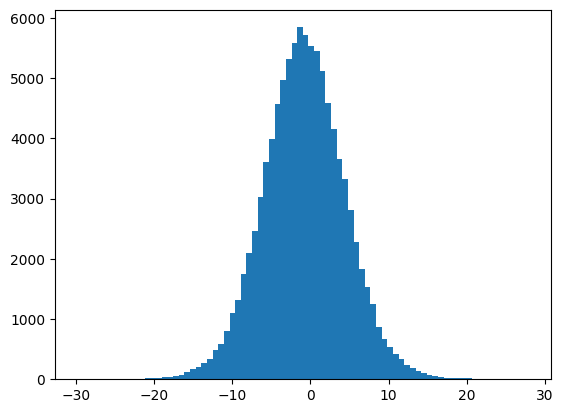

Mean PnL:      -0.7910
Std PnL:       5.2127
MSHE:          27.7974
CVaR (0.5):    -4.8830
CVaR (0.99):   -15.6277
Learned Price: 0.2450


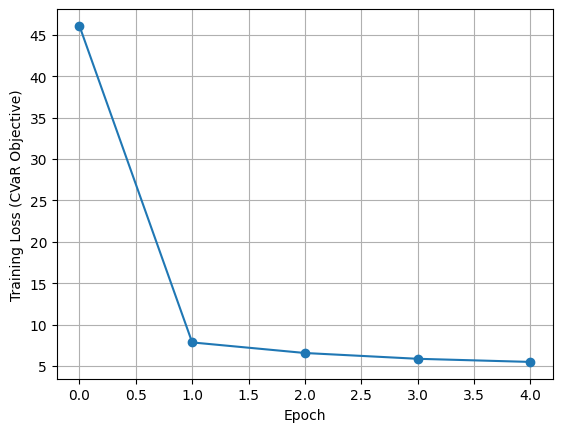

In [36]:
# Run main() if you want, or just rely on the notebook cells.
if __name__ == "__main__":
    main()